<a href="https://colab.research.google.com/github/serendipity343/CW2/blob/main/CW2_of_AIAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIAB CW2: Reality gap

This CW focusses on developing and exploring the braitenberg vehicle model in simulation and crossing this model over to a real world chassis. The braitenberg is a concept conceived in a thought experiment by Valentino Braitenberg. The idea is to develop what can be perceived as intelligent behaviour by simple wiring betwen lights sensors and wheel motors. This vehicle can exhibit a multitude of behaviours depedning on the wiring.

<img src="http://users.sussex.ac.uk/~christ/crs/kr-ist/copied-pics/braitenberg-vehicle2a-architecture.png" width="10%" style="display: block;margin-left: auto;margin-right: auto;" >

## Fear and aggression
If the sensor-motor connections are ipsilateral (left sensor to left motor, right sensors to right motor) then the agent steers away from the light as if it is afraid of it.
If on the other hand the sensor-motor connections are crossed (contralateral), the agents tend to approach the light in a agressive away.
If the stimulation is directly ahead, the vehicle moves directly towards it as before. But, if the stimulation is to one side, the vehicle will tend to veer towards it with increasing speed.

<img src="http://users.sussex.ac.uk/~christ/crs/kr-ist/copied-pics/braitenberg-vehicles-fear-v-aggression.png" width="20%" style="display: block;margin-left: auto;margin-right: auto;" >

[More about Braitenbergs](http://users.sussex.ac.uk/~christ/crs/kr-ist/lecx1a.html)

The physical robot build and library documentation can be found on [github](https://github.com/shepai/OpenEduBot)

Any problems with the lab sheet please email Dexter Shepherd at d.r.shepherd@sussex.ac.uk


## Installing libraries
Firstly we need to install the library for interfacing with the robots, and import all the required libraries


In [14]:
#!pip install mpremote
import numpy as np
import matplotlib.pyplot as plt
#from mpremote import pyboard
from copy import deepcopy
#import serial, glob, sys
import random

# Simulation
Simulation is a great way to develop a concept and train models as its low cost and quicker than real world implementation. There are problems with crossing this to the real world, which you will discover throughout this sheet.

## Setting up the braitenberg and environment

The braitenberg can have a genotype encoded to represent the different parts, and is always given starting positions

The environment allows you to run a trial for a set amount of time (T). It will plot the end result showing the path the agent has taken


In [15]:
class Braitenberg:
  """
  This class holds the genotype and position of the braigtenberg vihicle
  """
  def __init__(self,initial_pos,initial_bearing,geno):
    #@ param initial_pos is the starting pos
    #@ param initial_bearing is the starting direction of the board (degrees) e.g 45
    #@ param geno is the genotype to encode hardware e.g [w_ll w_lr w_rl w_rr bl br] encoded as 1 or 0
    self.geno=geno
    #assert (type(self.geno)==type([]) or type(self.geno)==type(np.array([]))) and len(self.geno)==6,"Genotype must be an array of size 6"
    self.initial_bearing = initial_bearing
    self.pos=initial_pos
  def get_geno(self):
    #@ returns the genotype options
    return self.geno

class environment:
  """
  allows running of a trial in a set up environment
  """
  def __init__(self, sig=0.01):
    # Initial setup
    self.dt=0.05;
    self.R =0.05; #radius
    self.b = 45; #(degrees) sensor anglr
    self.sig = sig

  def run(self,T,agent,motor_gain=0.5,show=True,S=(0,0)):
    #@ param T is the time it will run for
    #@ param agent is the braitenberg vehicle object used
    #@ param show is whether it will show the plot
    #@ returns 2D array of positions the agent has traveleld through [[x],[y]]
    #conver geno params
    w_ll,w_lr,w_rl,w_rr,bl,br = agent.get_geno()
    sl_pos = np.zeros((2,1));
    sr_pos = np.zeros((2,1));
    S=np.array(S)
    rho=np.zeros((2, 1));
    sensor_gain = 0.5;
    motor_gain =motor_gain;
    vl=0;vr=0;
    #convert to radians

    initial_bearing = agent.initial_bearing/360*2*np.pi;
    b=self.b/360*2*np.pi;

    pos = np.zeros((2,int(T/self.dt)));
    bearing = np.zeros((1,int(T/self.dt)));
    pos[:,0] = agent.pos;
    bearing[:,0] = initial_bearing;
    lightIntensity=np.zeros((2,int(T/self.dt)));

    for i in range(1, int(T/self.dt)):
        vc = (vl+vr)/2;
        va = (vr-vl)/(2*self.R);
        pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
        pos[1,i] = pos[1,i-1]+ self.dt*vc*np.sin(bearing[0,i-1]);
        bearing[0,i] = np.mod(bearing[0,i-1] + self.dt*va,2*np.pi);

        # Calculate left sensor position
        sl_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]+b);
        sl_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]+b);

        # Calculate right sensor position
        sr_pos[0] = pos[0,i] + self.R*np.cos(bearing[0,i]-b);
        sr_pos[1] = pos[1,i] + self.R*np.sin(bearing[0,i]-b);

        # Calculate (square) distance to element
        #this code assumes light is always at S
        dl = np.sqrt((sl_pos[0]-S[0])**2+(sl_pos[1]-S[1])**2);
        dr = np.sqrt((sr_pos[0]-S[0])**2+(sr_pos[1]-S[1])**2);

        #  Calculate local intensity
        il = sensor_gain/dl;
        ir = sensor_gain/dr;
        lightIntensity[0,i] = il
        lightIntensity[1,i] = ir
        #weights times inputs plus bias
        lm = il*w_ll + ir*w_rl + bl;
        rm = il*w_lr + ir*w_rr + br;
        # add a some gaussian noise to ech motor.
        # The sig variable controls how much noise is added
        lm = lm + np.random.normal(0, self.sig)
        rm = rm + np.random.normal(0, self.sig)

        #  Scale by motor gains
        vl =motor_gain*lm;
        vr =motor_gain*rm;
    if show:
      self.show(T,pos,sl_pos,sr_pos,bearing,b)
    return pos,lightIntensity
  def show(self,T,pos,sl_pos,sr_pos,bearing,b):
    plt.plot(pos[0,:],pos[1,:])
    #final postion
    x=pos[0,int(T/self.dt)-1];
    y= pos[1,int(T/self.dt)-1];
    f_bearing = bearing[0,int(T/self.dt)-1];
    # Calculate left sensor position
    sl_pos[0] = x + self.R*np.cos(f_bearing+b);
    sl_pos[1] = y + self.R*np.sin(f_bearing+b);
    # Calculate left sensor position
    sr_pos[0] = x + self.R*np.cos(f_bearing-b);
    sr_pos[1] = y + self.R*np.sin(f_bearing-b);

    plt.plot(0,0,marker='.',markersize=30,color='yellow');
    plt.plot(0,0,marker='o',markersize=10,color='black');

    # Plot  sensors
    plt.plot(sl_pos[0],sl_pos[1],marker='.',markersize=10,color='red');
    plt.plot(sr_pos[0],sr_pos[1],marker='.',markersize=10,color='red');

    # Plot body
    plt.plot( x, y,marker='.',markersize=10,color='blue');
    plt.plot(x,y,marker='o',markersize=10,color='black');
    #Plot trajkectory
    plt.pause(0.05)

    return pos

We can create an agent by generating 6 random numbers, 4 for the weights from each sensor to each motor and 2 bias terms for the motors. The strength of the weights represent which sensors are connected to which motors. Try running the following cell multiple times and see how the different random genotypes change the behaviour.


<img src="https://drive.google.com/uc?export=view&id=1pjR8HJUhmjibTUkhP_JkwuDYfCr4vlEE" width="80%" style="display: block;margin-left: auto;margin-right: auto;" >


**we may have to refine this figure to be clearer**




In [16]:
def generate_genotype():
  # The connection weights (wires) are random floating point numbers in the interval [0, 5)
  return np.random.rand(6)*5
# TODO make a simple Neural Controller here. and Bias cap.
genotype=generate_genotype()
print("This is what a genotype looks like",genotype)

# se the starting position and the bearing
starting_position = (0,3)
starting_bearing = 10 #bearing in degrees
runtime = 5 #run to 5 seconds

This is what a genotype looks like [1.37827525 3.05311082 2.35320729 1.36604131 0.69472732 1.97784192]


<ipython-input-15-332ffebea4a4>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-15-332ffebea4a4>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-15-332ffebea4a4>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-15-332ffebea4a4>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

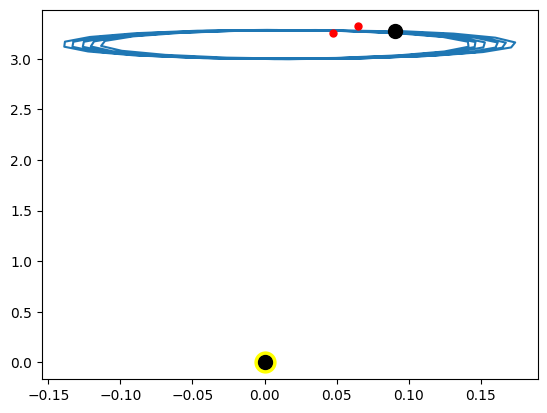

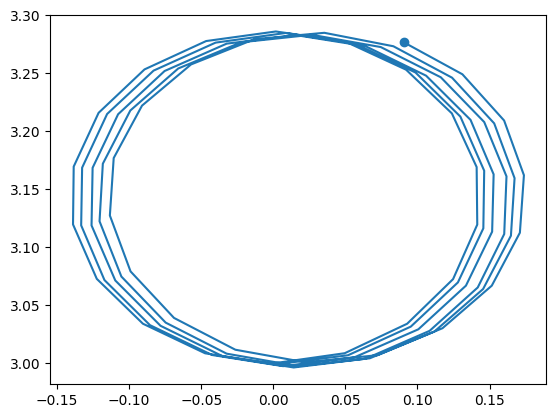

(2, 100) holds the (left sensor intensity, right sensor intensity)


In [17]:
agent=Braitenberg(starting_position, starting_bearing, genotype) #set up an agent with a random genotype
env=environment() #create the environment that the agent will run in
trajectory,intensities = env.run(runtime, agent,show=True)

# The trajectory variable hold the x, y coordinates
plt.plot(trajectory[0], trajectory[1])
plt.scatter(trajectory[0][-1],trajectory[1][-1])
plt.show()
print(intensities.shape,"holds the (left sensor intensity, right sensor intensity)")

## Task 1 - Evolving a solution
Using the genetic algorithms you developed in lab 2, you will need to create your own fitness function.

### 1.1
Knowing that the 'env.run(params)' function returns all the x and y coordinates, you can find how far the agent has travelled and how close the agent gets to the target.

Hint: You could use euclidean distance to calculate the start distance from the light source, to the end distance and gather the percentage of distance it has gained.

Hint hint: Each trajectory should be closer and closer to the light. This means the more trajectorys that are closer to the light than the previous trajectory... the better.

*count_of_trajectories_lower_than_prev/number_of_trajectories*



### 1.2
Create a mutation function for the genotype. Make sure to think about copy by reference and by value. You can make use of the [deepcopy](https://docs.python.org/3/library/copy.html) function. Click the link to see the documentation.

It is worth noting that unlike in lab sheet 2 where you could switch your genes from 1 to 0 and 0 to 1, there are far more values involved in this. Consider using gaussian generated noise on top of a genotype.


```
genotype+=np.random.normal(mean, standard_d, size=genotype.shape)
```

You may want to limit the values that the genotype can reach. This stops the values from tending to too large or too small.

```
genotype[geotype > max_value] = max_value
genotype[geotype < min_value] = min_value
```



### 1.3
Implement a Hill Climber that evolves your genotype

### 1.4
Implement the full Microbial GA

Task:
Problem :  evolve a 6 genes genotype to solve the braitenberg problem (follow the light)

1 - Learning phase.
2 - Select best genotype (test 100 random positions)
3- Test best genotype (again 100 random positions) = 1 bar Repeat 1,2,3 with
other parameter value to get another bar

In [18]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline
from typing import List, Dict
import math

<ipython-input-15-332ffebea4a4>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-15-332ffebea4a4>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-15-332ffebea4a4>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-15-332ffebea4a4>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

60 -458.8916978472142
Generation 0 best fitness (so far): -458.8916978472142
54 -871.0213463062189
Generation 1 best fitness (so far): -458.8916978472142
72 -550.515673833024
Generation 2 best fitness (so far): -458.8916978472142
61 -365.8743237369841
Generation 3 best fitness (so far): -365.8743237369841
15 -378.96757794460973
Generation 4 best fitness (so far): -365.8743237369841
37 -818.7820118644871
Generation 5 best fitness (so far): -365.8743237369841
20 -661.8341181479186
Generation 6 best fitness (so far): -365.8743237369841
13 -481.35771960782427
Generation 7 best fitness (so far): -365.8743237369841
75 -976.5335729382352
Generation 8 best fitness (so far): -365.8743237369841
48 -392.4799680419974
Generation 9 best fitness (so far): -365.8743237369841
79 -542.698421470597
Generation 10 best fitness (so far): -365.8743237369841
41 -919.1215035471075
Generation 11 best fitness (so far): -365.8743237369841
75 -366.5892384689252
Generation 12 best fitness (so far): -365.8743237369

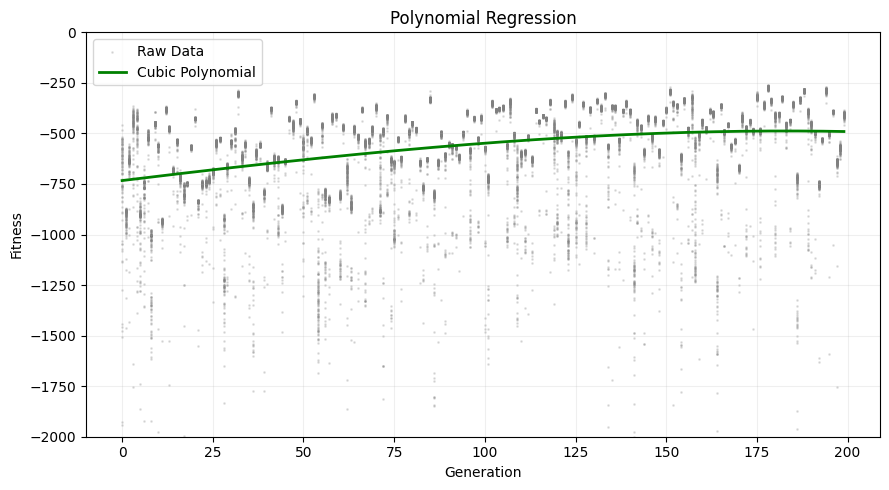

<ipython-input-15-332ffebea4a4>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-15-332ffebea4a4>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-15-332ffebea4a4>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-15-332ffebea4a4>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

Fitness of best genotype: -48.129746904292375
Best genotype found:
[ 6.5819637  -5.18229753 -0.16271961  0.22342851 11.36335951 11.8558029 ]


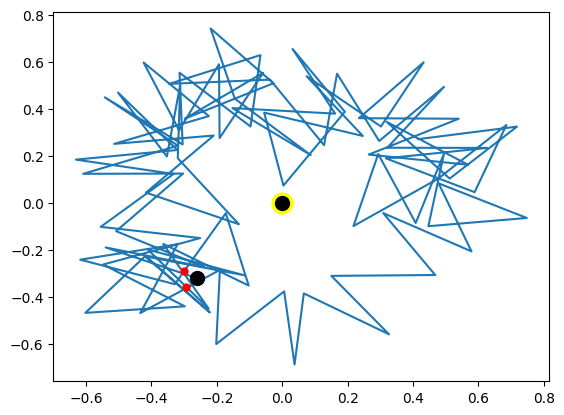

In [19]:
# SUMMED EUCLIDIAN DISTANCE
def fitness_function(positions, intensities, lightsource=(0, 0)):
    positions = np.array(positions)
    lightsource = np.array(lightsource)

    # Calculate distances from each position to the light source
    distances = np.linalg.norm(positions - lightsource[:, np.newaxis], axis=0)

    # Sum all distances (we return the negative because lower distance = better fitness)
    total_distance = np.sum(distances)

    return -total_distance

class GA:
    def __init__(self, pop_size: int, generations: int,
                 mutation_rate: float = 0.1, crossover_rate: float = 0.8, tournament_size: int = 3, nsimulations=5):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.nsimulations = nsimulations

        self.genotype_len = 6  # Number of genes per individual

        # Initialise population: each individual is a real-valued vector
        self.pop = self.initialise_pop()

    @staticmethod
    def generate_genotype():
        # Generate a genotype with random floating point numbers in the interval [0, 5).
        return np.random.rand(6) * 5

    def initialise_pop(self):
        # Create the initial population using generate_genotype.
        pop = np.array([self.generate_genotype() for _ in range(self.pop_size)])
        return pop

    def fitness(self,genotype, starting_position, starting_bearing):
        # Note: The following functions/classes (Braitenberg, environment, etc.)
        # must be defined in your full code.

        agent = Braitenberg(starting_position, starting_bearing, genotype)  # Setup agent with genotype
        env = environment()  # Create the environment
        trajectory, intensities = env.run(runtime, agent, show=False)
        return fitness_function(trajectory, intensities)

    def evaluate_population(self):
        # Evaluate each individual in the population
        fitness_values = np.zeros(len(self.pop))

        for i in range(self.nsimulations):
          start_x = np.random.uniform(-2, 2)
          start_y = np.random.uniform(-2, 2)
          start_bearing = np.random.uniform(0, 360)
          starting_position = [start_x, start_x]
          fitness_values += np.array([self.fitness(ind, starting_position, starting_bearing) for ind in self.pop])

        #fitness_values = np.array([self.fitness(ind, starting_position, starting_bearing) for ind in self.pop])
        return fitness_values

    def tournament_selection(self, fitness_values):
        # Select one individual using tournament selection.
        indices = np.random.choice(np.arange(self.pop_size), self.tournament_size, replace=False)
        tournament = self.pop[indices]
        tournament_fitness = fitness_values[indices]
        winner_index = np.argmax(tournament_fitness)
        return tournament[winner_index].copy()

    def crossover(self, parent1, parent2):
        # One-point crossover.
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.genotype_len)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutate(self, genotype, mean, standard_d):
        for i in range(self.genotype_len):
            if np.random.rand() < self.mutation_rate:
                # genotype[i] = 1 - genotype[i]
                genotype[i] += np.random.normal(mean, standard_d, size=genotype[i].shape)
        return genotype

    def evolve(self):
      total_best_genotype = None
      total_best_fitness = -np.inf
      fitness_history = []

      for gen in range(self.generations):
          # Evaluate all fitnesses in this population and get best
          fitness_values = self.evaluate_population()
          current_best_index = np.argmax(fitness_values)
          current_best_fitness = fitness_values[current_best_index]

          print(current_best_index, current_best_fitness)

          # Update best-so-far if the current generation's best is better
          if current_best_fitness > total_best_fitness:
              total_best_fitness = current_best_fitness
              total_best_genotype = self.pop[current_best_index].copy()
          # Store best-so-far fitness instead of current generation best
          fitness_history.append(fitness_values)#total_best_fitness)
          print(f"Generation {gen} best fitness (so far): {total_best_fitness}")

          new_pop = []

          # Global Elitism: Always keep the best-so-far individual
          new_pop.append(total_best_genotype.copy())

          # Generate new individuals until new_pop is full
          while len(new_pop) < self.pop_size:
              parent1 = self.tournament_selection(fitness_values)
              parent2 = self.tournament_selection(fitness_values)
              child1, child2 = self.crossover(parent1, parent2)
              child1 = self.mutate(child1, 0, 0.2)
              # Ensure we add child2 only if there is room in the population
              if len(new_pop) < self.pop_size:
                  child2 = self.mutate(child2, 0, 0.2)
                  new_pop.append(child1.copy())
                  new_pop.append(child2.copy())
              else:
                  new_pop.append(child1.copy())
          assert new_pop[0].all()==total_best_genotype.all(),"shit"
          # Update population
          self.pop = np.array(new_pop[:self.pop_size])
          assert self.pop[0].all()==total_best_genotype.all(),"shit"

      # Plotting fitness history over generations
      # Flatten generation numbers and fitness values
      x_vals = np.array([[x]*100 for x in range(self.generations)]).flatten()
      y_vals = np.array(fitness_history).flatten()

      # Sort x and y based on x for interpolation
      sorted_indices = np.argsort(x_vals)
      x_sorted = x_vals[sorted_indices]
      y_sorted = y_vals[sorted_indices]

      # Fit a spline with a reasonable smoothness parameter
      spline = UnivariateSpline(x_sorted, y_sorted, s=len(x_vals) * 10)
      x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 100)
      y_smooth = spline(x_smooth)

      def plot_fitness_curve(x_vals, y_vals, window_size=20):
          plt.figure(figsize=(9, 5))
          x = np.array(x_vals)
          y = np.array(y_vals)

          # Clean data
          mask = np.isfinite(y)
          x_clean = x[mask]
          y_clean = y[mask]

          # Create common x-axis for smooth plots
          x_smooth = np.linspace(min(x_clean), max(x_clean), 500)

          # Plot raw data
          plt.scatter(x_clean, y_clean, s=1, alpha=0.2, color='gray', label="Raw Data")

          # Polynomial Regression (Green)
          try:
              model = make_pipeline(
                  PolynomialFeatures(degree=3),
                  LinearRegression()
              )
              model.fit(x_clean.reshape(-1, 1), y_clean)
              y_poly = model.predict(x_smooth.reshape(-1, 1))
              plt.plot(x_smooth, y_poly, 'g-', linewidth=2,
                      label="Cubic Polynomial")
          except Exception as e:
              print(f"Polynomial regression failed: {e}")

          plt.xlabel("Generation")
          plt.ylabel("Fitness")
          plt.ylim(-2000, 0)
          plt.title("Polynomial Regression")
          plt.legend()
          plt.grid(alpha=0.2)
          plt.tight_layout()
          plt.show()

      plot_fitness_curve(x_vals, y_vals, window_size=20)

      return total_best_genotype, y_vals


runtime = 5
ga = GA(pop_size=100, generations=200, mutation_rate=0.2, crossover_rate=0.8, tournament_size=5, nsimulations=5)
best, yvals = ga.evolve()
start_x = np.random.uniform(-2, 2)
start_y = np.random.uniform(-2, 2)
start_bearing = np.random.uniform(0, 360)
starting_position = [start_x, start_y]

print("Fitness of best genotype:", ga.fitness(best, starting_position, start_bearing))

print("Best genotype found:")
print(best)
#print("Fitness of best genotype:", ga.fitness(best))

# run this best genotype in simulation to see how it performs
agent = Braitenberg(starting_position, starting_bearing, best)  # Setup agent with genotype
env = environment()  # Create the environment
trajectory, intensities = env.run(runtime, agent, show=True)

Fitness of best genotype: -48.41574032743837
Best genotype found:
[ 6.5819637  -5.18229753 -0.16271961  0.22342851 11.36335951 11.8558029 ]


<ipython-input-15-332ffebea4a4>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-15-332ffebea4a4>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-15-332ffebea4a4>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-15-332ffebea4a4>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

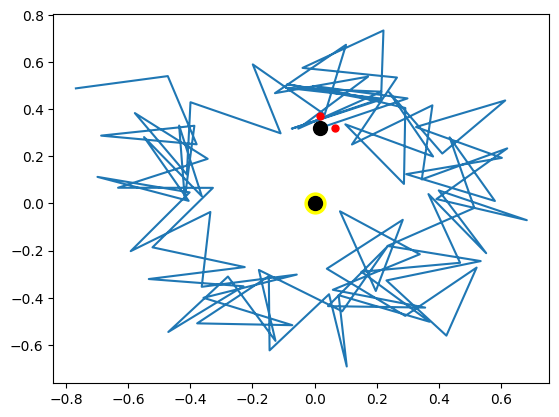

In [46]:
runtime = 5
ga = GA(pop_size=100, generations=200, mutation_rate=0.2, crossover_rate=0.8, tournament_size=5, nsimulations=5)
start_x = np.random.uniform(-1, 1)
start_y = np.random.uniform(-1, 1)
start_bearing = np.random.uniform(0, 360)
starting_position = [start_x, start_y]

print("Fitness of best genotype:", ga.fitness(best, starting_position, start_bearing))
print("Best genotype found:")
print(best)
#print("Fitness of best genotype:", ga.fitness(best))

# run this best genotype in simulation to see how it performs
agent = Braitenberg(starting_position, starting_bearing, best)
env = environment()  # Create the environment
trajectory, intensities = env.run(runtime, agent, show=True)

In [ ]:
# SUMMED EUCLIDIAN DISTANCE
import numpy as np

def fitness_function(positions, intensities, lightsource=(0, 0)):
    positions = np.array(positions)
    lightsource = np.array(lightsource)
    distances = np.linalg.norm(positions - lightsource[:, np.newaxis], axis=0)
    return -np.sum(distances)

class GA:
    def __init__(self, pop_size: int, generations: int,
                 mutation_rate: float = 0.1, crossover_rate: float = 0.8,
                 tournament_size: int = 3, nsimulations=5):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.nsimulations = nsimulations
        self.genotype_len = 6
        self.pop = self.initialise_pop()

    @staticmethod
    def generate_genotype():
        return np.random.rand(6) * 5

    def initialise_pop(self):
        return np.array([self.generate_genotype() for _ in range(self.pop_size)])

    def fitness(self, genotype, starting_position, starting_bearing):
        agent = Braitenberg(starting_position, starting_bearing, genotype)
        env = environment()
        traj, intens = env.run(runtime, agent, show=False)
        return fitness_function(traj, intens)

    def evaluate_population(self):
        fitness_values = np.zeros(self.pop_size)
        for _ in range(self.nsimulations):
            sx, sy = np.random.uniform(-2, 2, size=2)
            bearing = np.random.uniform(0, 360)
            fitness_values += np.array([
                self.fitness(ind, [sx, sy], bearing) for ind in self.pop
            ])
        return fitness_values

    def tournament_selection(self, fitness_values):
        idxs = np.random.choice(self.pop_size, self.tournament_size, replace=False)
        winner = idxs[np.argmax(fitness_values[idxs])]
        return self.pop[winner].copy()

    def crossover(self, p1, p2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.genotype_len)
            return np.concatenate([p1[:point], p2[point:]]), np.concatenate([p2[:point], p1[point:]])
        return p1.copy(), p2.copy()

    def mutate(self, geno, mean, std):
        for i in range(self.genotype_len):
            if np.random.rand() < self.mutation_rate:
                geno[i] += np.random.normal(mean, std)
        return geno

    def evolve(self):
        total_best = None
        best_fit = -np.inf
        history = []
        for gen in range(self.generations):
            fits = self.evaluate_population()
            idx = np.argmax(fits)
            if fits[idx] > best_fit:
                best_fit = fits[idx]
                total_best = self.pop[idx].copy()
            history.append(fits)
            new_pop = [total_best.copy()]
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(fits)
                p2 = self.tournament_selection(fits)
                c1, c2 = self.crossover(p1, p2)
                new_pop.append(self.mutate(c1, 0, 0.2))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self.mutate(c2, 0, 0.2))
            self.pop = np.array(new_pop[:self.pop_size])
        return total_best, history

runtime = 5
ga = GA(100, 200, 0.2, 0.8, 5, 5)
best, hist = ga.evolve()
print("Best fitness:", np.max(hist[-1]))
print("Best genotype:", best)


<ipython-input-18-45d70219f73d>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-18-45d70219f73d>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-18-45d70219f73d>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-18-45d70219f73d>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

Best fitness: -476.33372433141193
Best genotype: [-0.48676844  2.92755093 -3.89079236  3.01706585 11.86975904 10.81973793]


=== Comparing pop_size ===
Evaluating pop_size = 10


<ipython-input-18-45d70219f73d>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[0,i] = il
<ipython-input-18-45d70219f73d>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lightIntensity[1,i] = ir
<ipython-input-18-45d70219f73d>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[0,i] = pos[0,i-1]+ self.dt*vc*np.cos(bearing[0,i-1]);
<ipython-input-18-45d70219f73d>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depreca

Average fitness: -134.028809174105

Evaluating pop_size = 20
Average fitness: -169.40765200355503

Evaluating pop_size = 50
Average fitness: -163.54637071256957

Evaluating pop_size = 100
Average fitness: -127.9706386088472

Evaluating pop_size = 200
Average fitness: -117.1162268645464



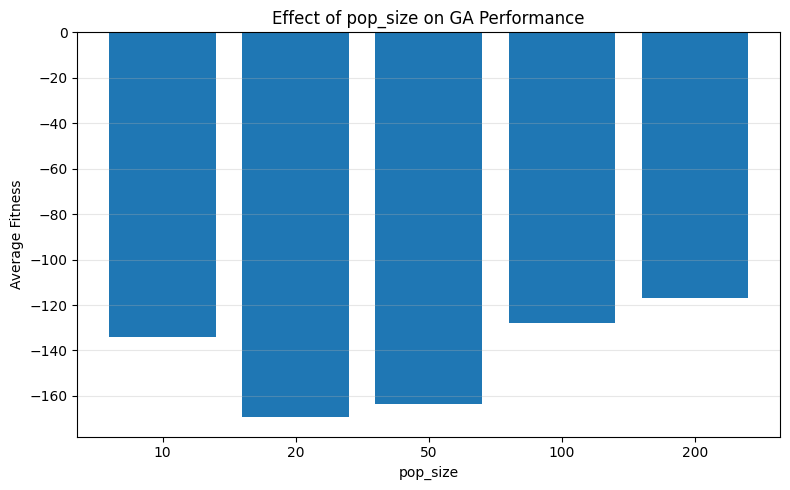

Results for pop_size: {10: -134.028809174105, 20: -169.40765200355503, 50: -163.54637071256957, 100: -127.9706386088472, 200: -117.1162268645464}

=== Comparing generations ===
Evaluating generations = 10
Average fitness: -127.94064415891424

Evaluating generations = 20
Average fitness: -206.41005512744863

Evaluating generations = 50
Average fitness: -140.34554148711385

Evaluating generations = 100
Average fitness: -127.09238886635379

Evaluating generations = 200
Average fitness: -167.16782725077636



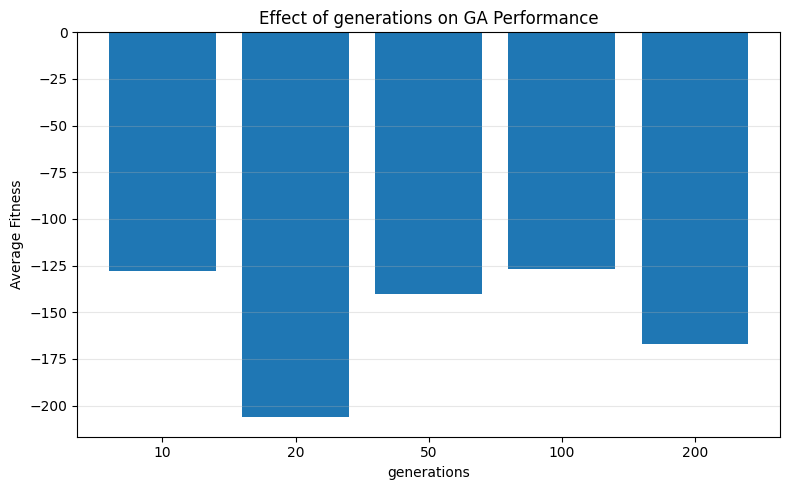

Results for generations: {10: -127.94064415891424, 20: -206.41005512744863, 50: -140.34554148711385, 100: -127.09238886635379, 200: -167.16782725077636}

=== Comparing mutation_rate ===
Evaluating mutation_rate = 0.01
Average fitness: -125.96613496186811

Evaluating mutation_rate = 0.05
Average fitness: -135.70810949456975

Evaluating mutation_rate = 0.1
Average fitness: -144.01679274187723

Evaluating mutation_rate = 0.2
Average fitness: -135.57370521061006

Evaluating mutation_rate = 0.3
Average fitness: -162.57621529819082



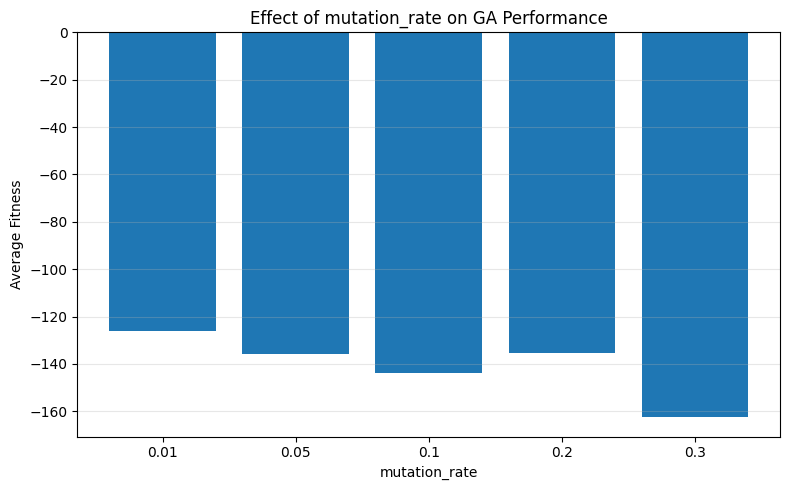

Results for mutation_rate: {0.01: -125.96613496186811, 0.05: -135.70810949456975, 0.1: -144.01679274187723, 0.2: -135.57370521061006, 0.3: -162.57621529819082}

=== Comparing crossover_rate ===
Evaluating crossover_rate = 0.1
Average fitness: -123.9436449699937

Evaluating crossover_rate = 0.2
Average fitness: -170.03068594642315

Evaluating crossover_rate = 0.5
Average fitness: -145.99283792956948

Evaluating crossover_rate = 0.75
Average fitness: -166.31299983199722

Evaluating crossover_rate = 0.85
Average fitness: -129.23527024414898



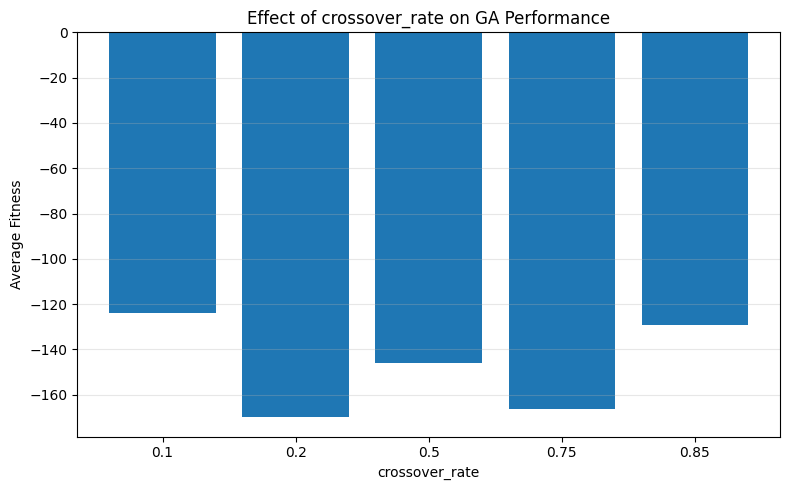

Results for crossover_rate: {0.1: -123.9436449699937, 0.2: -170.03068594642315, 0.5: -145.99283792956948, 0.75: -166.31299983199722, 0.85: -129.23527024414898}

=== Comparing tournament_size ===
Evaluating tournament_size = 1
Average fitness: -164.43201377011735

Evaluating tournament_size = 2
Average fitness: -121.78298535645911

Evaluating tournament_size = 5
Average fitness: -123.07041419676386

Evaluating tournament_size = 10
Average fitness: -152.6627157017976

Evaluating tournament_size = 20
Average fitness: -147.25217933804817



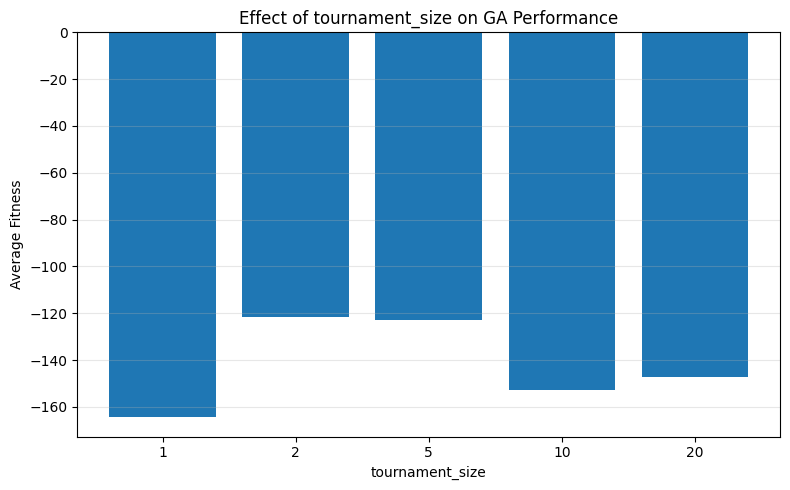

Results for tournament_size: {1: -164.43201377011735, 2: -121.78298535645911, 5: -123.07041419676386, 10: -152.6627157017976, 20: -147.25217933804817}

=== Comparing nsimulations ===
Evaluating nsimulations = 1
Average fitness: -193.03177718384433

Evaluating nsimulations = 2
Average fitness: -137.76436413458507

Evaluating nsimulations = 5
Average fitness: -148.72875111392446

Evaluating nsimulations = 10
Average fitness: -154.9001019332761

Evaluating nsimulations = 20
Average fitness: -135.65120356664556



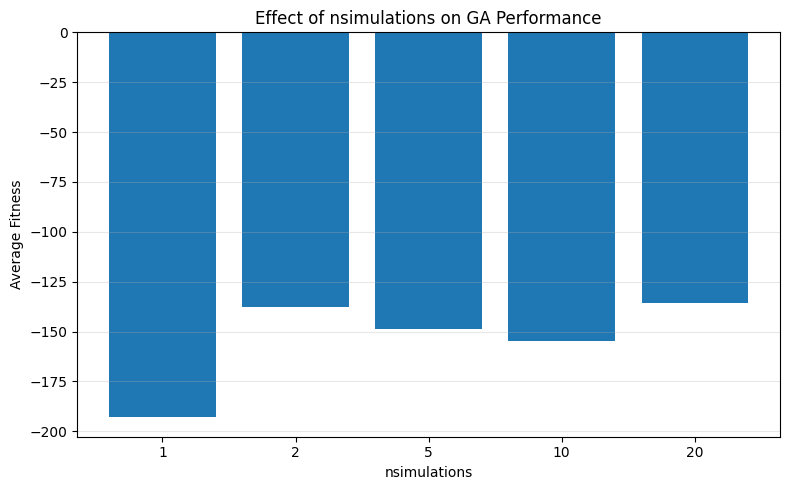

Results for nsimulations: {1: -193.03177718384433, 2: -137.76436413458507, 5: -148.72875111392446, 10: -154.9001019332761, 20: -135.65120356664556}

Testing start distance = 1
Distance 1, average fitness: -60.826106634245576

Testing start distance = 2
Distance 2, average fitness: -158.6226785656969

Testing start distance = 3
Distance 3, average fitness: -450.8924037363316



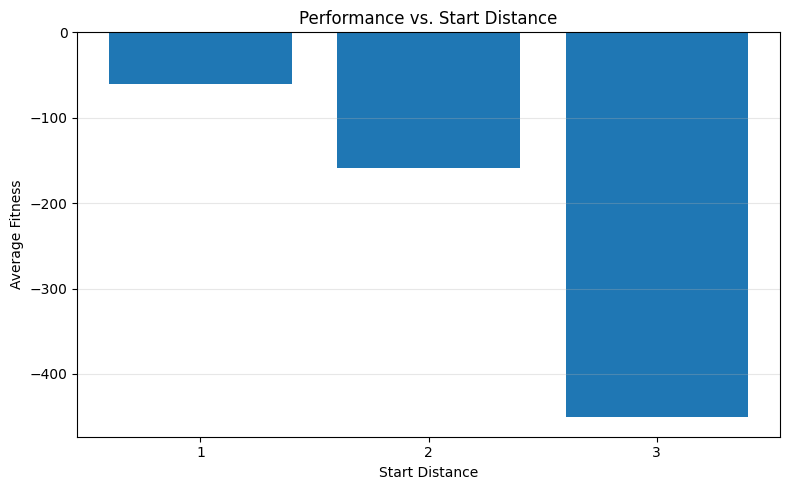

{1: -60.826106634245576, 2: -158.6226785656969, 3: -450.8924037363316}


In [ ]:
# Assumes Braitenberg, environment, fitness_function, and GA classes are already defined in the namespace
def train_ga(pop_size: int,
             generations: int,
             mutation_rate: float,
             crossover_rate: float,
             tournament_size: int,
             nsimulations: int):
    """
    Training phase: run the GA with given hyperparameters and return the best genotype found.
    """
    ga = GA(pop_size=pop_size,
            generations=generations,
            mutation_rate=mutation_rate,
            crossover_rate=crossover_rate,
            tournament_size=tournament_size,
            nsimulations=nsimulations)
    best_genotype, _ = ga.evolve()
    return best_genotype


def evaluate_genotype(genotype: np.ndarray,
                      n_trials: int,
                      runtime: float = 5.0) -> float:
    """
    Test a genotype over multiple random starting positions and return the average fitness.
    """
    fitnesses = []
    for _ in range(n_trials):
        x = np.random.uniform(-2, 2)
        y = np.random.uniform(-2, 2)
        bearing = np.random.uniform(0, 360)
        agent = Braitenberg([x, y], bearing, genotype)
        env = environment()
        positions, intensities = env.run(runtime, agent, show=False)
        fitnesses.append(fitness_function(positions, intensities))
    return float(np.mean(fitnesses))


def compare_hyperparams_bar(param_name: str,
                             values: List,
                             fixed_params: Dict,
                             train_runtime: float = 5.0,
                             test_trials: int = 100) -> Dict:
    """
    Compare different hyperparameter values using a bar chart:
    1. For each value, run training (train_phase) to get best genotype.
    2. Evaluate this genotype twice, each with test_trials samples.
    3. Use the average of both evaluations as the bar height.
    Returns a dict mapping parameter value to average fitness.
    """
    results = {}
    for v in values:
        print(f"Evaluating {param_name} = {v}")
        params = fixed_params.copy()
        params[param_name] = v
        # Training phase
        best = train_ga(pop_size=params['pop_size'],
                        generations=params['generations'],
                        mutation_rate=params['mutation_rate'],
                        crossover_rate=params['crossover_rate'],
                        tournament_size=params['tournament_size'],
                        nsimulations=params['nsimulations'])
        # Testing phase: two rounds
        f1 = evaluate_genotype(best, test_trials, runtime=train_runtime)
        f2 = evaluate_genotype(best, test_trials, runtime=train_runtime)
        avg_fit = (f1 + f2) / 2
        results[v] = avg_fit
        print(f"Average fitness: {avg_fit}\n")
    # Plot bar chart
    plt.figure(figsize=(8, 5))
    plt.bar([str(v) for v in values], [results[v] for v in values])
    plt.xlabel(param_name)
    plt.ylabel('Average Fitness')
    plt.title(f'Effect of {param_name} on GA Performance')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return results

# Example usage:
fixed_params = {
    'pop_size': 100,
    'generations': 100,
    'mutation_rate': 0.1,
    'crossover_rate': 0.8,
    'tournament_size': 5,
    'nsimulations': 3
}

search_space = {
    'pop_size': [10, 20, 50, 100, 200],
    'generations': [10, 20, 50, 100, 200],
    'mutation_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'crossover_rate': [0.1, 0.2, 0.5, 0.75, 0.85],
    'tournament_size': [1, 2, 5, 10, 20],
    'nsimulations': [1, 2, 5, 10, 20]
}

for param, vals in search_space.items():
    print(f"=== Comparing {param} ===")
    params = fixed_params.copy()
    params[param] = None  # placeholder overwritten inside function
    results = compare_hyperparams_bar(param, vals, fixed_params)
    print(f"Results for {param}: {results}\n")


def evaluate_at_distance(genotype: np.ndarray,
                         n_trials: int,
                         distance: float,
                         runtime: float = 5.0) -> float:
    """
    Test a genotype starting uniformly on a circle of given radius.
    Return average fitness over n_trials.
    """
    fitnesses = []
    for _ in range(n_trials):
        theta = np.random.uniform(0, 2 * math.pi)
        x = distance * math.cos(theta)
        y = distance * math.sin(theta)
        bearing = np.random.uniform(0, 360)
        agent = Braitenberg([x, y], bearing, genotype)
        env = environment()
        positions, intensities = env.run(runtime, agent, show=False)
        fitnesses.append(fitness_function(positions, intensities))
    return float(np.mean(fitnesses))


def compare_start_distance(distances: List[float],
                           fixed_params: Dict,
                           train_runtime: float = 5.0,
                           test_trials: int = 100) -> Dict:
    """
    Compare GA performance for different starting distances:
    1. Train GA with fixed_params to get best genotype.
    2. For each distance, evaluate the genotype twice using evaluate_at_distance.
    3. Plot and return average fitness per distance.
    """
    best = train_ga(pop_size=fixed_params['pop_size'],
                    generations=fixed_params['generations'],
                    mutation_rate=fixed_params['mutation_rate'],
                    crossover_rate=fixed_params['crossover_rate'],
                    tournament_size=fixed_params['tournament_size'],
                    nsimulations=fixed_params['nsimulations'])
    results = {}
    for d in distances:
        print(f"Testing start distance = {d}")
        f1 = evaluate_at_distance(best, test_trials, d, runtime=train_runtime)
        f2 = evaluate_at_distance(best, test_trials, d, runtime=train_runtime)
        avg_fit = (f1 + f2) / 2
        results[d] = avg_fit
        print(f"Distance {d}, average fitness: {avg_fit}\n")
    plt.figure(figsize=(8, 5))
    plt.bar([str(d) for d in distances], [results[d] for d in distances])
    plt.xlabel('Start Distance')
    plt.ylabel('Average Fitness')
    plt.title('Performance vs. Start Distance')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return results

distances = [1, 2, 3]
res = compare_start_distance(distances, fixed_params)
print(res)


## Task 2 - Tweaking the parameters

### 2.1
Change the noise with the simulation. The world is noisy and makes it harder for an agent to adapt to an environment. Experiment with noise in the simulation and see how this affects your accuracies against the less noisy simulations. Does more noise affect accuracy? Is the difference insignificant?

`environment(sig=0.1) `
Changes the noise levels


### 2.2 (Optional)
Experiment with different genotype sizes. The lines


```
w_ll,w_lr,w_rl,w_rr,bl,br = agent.get_geno()
```



```
#weights times inputs plus bias
lm = il*w_ll + ir*w_rl + bl;
rm = il*w_lr + ir*w_rr + br;
```

Both in the environment class, these encode the values that we move the motors by. Try having a larger genotype, think about network architecture to how many you will need. If you added a hidden layer of three nodes, you would need 6 weights from the inputs and 6 weights to the output. Then 5 optional biases.

If you are stuck with this one, here is some code that you can add to your environment class. It allows you to enter network layer sizes, and it will tell you how large your genotype should be, and what indicies will need to be broken up. eg [0:8] (input weights), [8:12] (biases), [12:20] (output weights) for a genotype for a network of 2 inputs, 4 hidden nodes, 4 biases and 2 outputs.



```
def gen_geno_size(self,layers=[4]):
    layers.append(2) #add the output layers
    #given an array of layer sizes eg [2,3,4] calculate the idxs of the genotype and layer size
    ids=[]
    ids.append(2*layers[0])#weights
    ids.append(2*layers[0]+ layers[0])#bias
    last=ids[-1]
    for i in range(1,len(layers)): #loop through hidden and output
      layer=layers[i]
      ids.append(last+ layers[i-1]*layer) #weight matrix
      ids.append(last+ layers[i-1]*layer + layer) #bias matrix
      last=ids[-1] #last point in array
    return sum(ids),ids
```

You will need to generate a genotype of size `sum(ids)` and generate the weight matrices and bias matrices using the genotype data.


We can then replace the part of the code that performs the left and right multiplication with the multiplication through the layers:



```
#  Calculate local intensity
il = np.array(sensor_gain/dl)
ir = np.array(sensor_gain/dr)
#weights times inputs plus bias

m=np.array([il,ir]).T #initial inputs
for i in range(0,len(weights)):
   m = np.dot(m,weights[i]) + biases[i] #caclulation through network
#get output values
lm=m[0][0]
rm=m[0][1]
```







# Physical robot

The physical robot makes use of light sensors and two motors. Like the simulation, we can encode this information of what to use and what not to use into the physical robot.

<img src="https://raw.githubusercontent.com/shepai/OpenEduBot/main/Assets/wheelBot.jpg" width="25%" >

We can attach a USB to it and upload the agent code with the trained genotype. You can also edit this code to improve the noise reduction.

The following code will not work in colab as it needs to pass across the serial ports, and the local serial ports for your colab file is a google server somewhere else in the world!



## Using a different IDE
Using a different IDE can be simpler for using MicroPython. [Thonny IDE](https://thonny.org/) is a simple IDE for uploading programs to the Raspberry Pi Pico. Once you have set up the IDE we can start [programming the board](https://projects.raspberrypi.org/en/projects/getting-started-with-the-pico).

### Step 1
Download the robot control library from [Github](https://raw.githubusercontent.com/shepai/OpenEduBot/main/Library/EduBot_CP.py) and have handy in a folder.

### Step 2
You will need to connect the robot to your device via USB. Make sure you have Thonny IDE up. In the bottom right corner you should be able to select the interpreter for the IDE. We want Raspberry Pi Pico [CircuitPython](https://learn.adafruit.com/getting-started-with-raspberry-pi-pico-circuitpython/circuitpython?gad_source=1&gclid=CjwKCAjwte-vBhBFEiwAQSv_xTJQbOabX5Z59ITlxfXICid4vbXu94T_lZnswAgxNadApLhsq4NA3BoCEPsQAvD_BwE).

<img src="https://projects-static.raspberrypi.org/projects/getting-started-with-the-pico/725a421f3b51a5674c539d6953db5f1892509475/en/images/thonny-micropython-pico-menu.png" width="35%" >

The software will ask you to install firmware for the Pico. Install it. Yours should say circuitpython

<img src="https://projects-static.raspberrypi.org/projects/getting-started-with-the-pico/725a421f3b51a5674c539d6953db5f1892509475/en/images/thonny-install-micropython-pico.png" width="35%" >

The shell should then show it is connected to the Pico. Try entering the following in the shell:

```
print("Hello, world!")
```

This code is compiling on the Pico board. Any code they you write and run will now be uploading to the device.


### Step 3
Open the downloaded EduBot_CP.py in the Thonny IDE, and then go to File>Save As and a prompt will come up asking whether to install on the device or computer. Resave the file on the device with the same name. We do this so we can control the chassis hardware.

### Step 4
Within this colab folder save the genotypes that you wish to upload to the board. These can be saved directly on the device as well, or can be copied across manually into the code with copy and paste.
```
np.save("path/to/file",best_genotype)
```

## Using the robot

### Dependencies

- CircuitPython
All can be found under the (adafruit circuitpython library bundle)[https://circuitpython.org/libraries]
    1. simpleio
    2. adafruit_motor


## CircuitPython
CircuitPython is an open-source derivative of the MicroPython programming language targeted toward students and beginners.

```
from EduBot_CP import wheelBot

bot = wheelBot()
```

Using CircuitPython with the Pico and robotics hat you will need to use:

```
from EduBot_CP import wheelBot

bot = wheelBot(board_type="pico")
```

In order for it to work with the Pico and motor driver board, you must add the following parameter.
```
from EduBot_CP import wheelBot

bot = wheelBot(board_type="pico_1")
```

## MicroPython
MicroPython is the default variant of python electronics on the Raspberry Pi Pico. The library has been developed for many chassis.

```
from EduBot import wheelBot

bot = wheelBot()
```
In order for it to work with the Pico and robotics board, you must add the following parameter.
```
from EduBot_CP import wheelBot

bot = wheelBot(board_type="pico")
```
In order for it to work with the Pico and (Kitroniks motor driver board)[https://thepihut.com/products/motor-driver-board-for-raspberry-pi-pico], you must add the following parameter.
```
from EduBot import wheelBot

bot = wheelBot(board_type="pico_1")




We need to download the robot control library and upload it to the board.

In [ ]:
!wget https://raw.githubusercontent.com/shepai/OpenEduBot/main/Library/EduBot.py

--2025-04-12 23:04:22--  https://raw.githubusercontent.com/shepai/OpenEduBot/main/Library/EduBot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16434 (16K) [text/plain]
Saving to: ‘EduBot.py’

EduBot.py           100%[===================>]  16.05K  --.-KB/s    in 0.002s  

2025-04-12 23:04:23 (9.85 MB/s) - ‘EduBot.py’ saved [16434/16434]



#Sim2Real

The following is the code that is needed on board, which will need to be copied across and saved as main.py

In [ ]:
# """
# Braightenberg robot for crossing the reality gap
# The light sensors allow light following behaviours.

# The sensor pins are read at 26 and 27, if the robot is not turning away from the collision,
# consider switching the pins around (26 & 27).

# Code by Dexter R Shepherd

# """

# from EduBot_CP import wheelBot
# import time
# import board
# from analogio import AnalogIn

# s1 = AnalogIn(board.GP27)
# s2 = AnalogIn(board.GP26)

# #change the sensor gain to preference
# sensor_gain=0.5
# def get_intensity(pin):
#     return (pin.value*3.3) /65536

# def calc(genotype):
#     w_ll,w_lr,w_rl,w_rr,bl,br = (genotype[0],genotype[1],genotype[2],genotype[3],genotype[4],genotype[5])
#     # Calculate (square) distance to element
#     #  Calculate local intensity
#     il,ir=(get_intensity(s1)*10,get_intensity(s2)*10)

#     #weights times inputs plus bias
#     lm = il*w_ll + ir*w_rl + bl;
#     rm = il*w_lr + ir*w_rr + br;
#     print("sensor:",il,ir)
#     print("motor:",lm,rm)
#     return lm,rm

# # Define bot instance
# bot = wheelBot(board_type="pico")

# genotype = [1.78784589,3.69787373,1.74029442,2.69019234,4.02527834,3.36748279]


# # Test move
# speed = 1000
# bot.forward(speed) # Activate both motors
# time.sleep(1) # Wait for 1 second
# bot.stop() # Stops both motors
# sensitivity = 1

# while True:
#     # Do this for both motors
#     lm, rm = calc(genotype)

#     # Convert the computed commands to a speed in the range 0-100
#     # (This scaling/clamping may need to be adjusted for your robot and sensors)
#     lm_speed = max(0, min(100, int(abs(lm)))) * sensitivity
#     rm_speed = max(0, min(100, int(abs(rm)))) * sensitivity
#     print(">",lm_speed,rm_speed)

#     # Determine motor direction: forward if positive, reverse if negative
#     lm_direction = "r" if lm >= 0 else "f"
#     rm_direction = "r" if rm >= 0 else "f"

#     # Map motor 3 to left and motor 4 to right (adjust if your wiring is different)
#     bot.motorOn(3, lm_direction, lm_speed)
#     bot.motorOn(4, rm_direction, rm_speed)

#     # A short delay between updates (adjust as needed)
#     time.sleep(0.1)


## Task 3 - Crossing the reality gap

This task is about finding unique solutions to improving the crossing of the reality gap

### 3.1

**Either**

Upload your best genotypes to the robot and watch the behaviours, what do you notice about the agent compared to simulation?

Attempt to play around with sensor_gain, using a physical screw to change the threshold of sensitivity on the sensors, and any other hyperparameters you can think of.

**Or**

Try manually code a braitenberg robot on the robot. Are there algorithms or behaviours that worked well in simulation that you want?

### 3.2 (optional)
Play around with the source code that is being uploaded. Perhaps add noise to the sensors, or more sensors?